In [1]:
import numpy as np
import torch

c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Bacon著 question 3 08/12/2023
from torch.nn.functional import unfold
import torch
from torch import nn
import torch.nn.functional as F

class Conv2D(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=(3,3),stride=1,padding=1):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, input_batch):
        b, c, h, w = input_batch.size()

        #add padding
        padded_input = F.pad(input_batch, (self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)

        k_h ,k_w = self.kernel_size
        #number in each kernel

        kernel_num = k_h * k_w

        k = k_h * k_w * c

        out_w = (w - k_w + 2 * self.padding) // self.stride + 1
        out_h = (h - k_h + 2 * self.padding) // self.stride + 1

        #form of reference of position

        refernce_position = torch.arange(0,out_h*out_w).reshape(out_h,out_w)


        out_unfold = torch.zeros(b, k ,out_h * out_w)
        #print(padded_input)
        # Unfold input: b, c, h, w -> b, c*k, h*w
        for bs in range(b):

            for i in range(out_h):
                for j in range(out_w):
                    for c in range(self.in_channels):
                        start_w = j * self.stride
                        start_h = i * self.stride

                        kernal_unfold = padded_input[bs, c, start_h:start_h + k_h, start_w:start_w + k_w].reshape(-1)
                        out_position = refernce_position[i,j]
                        #print(channel_range_0,channel_range_1)
                        out_unfold[0,kernel_num*c:kernel_num*(c+1),out_position] = kernal_unfold


                       # out_unfold[bs, channel_start_position*k+c*kernel_num:channel_start_position*k+(c+1)*kernel_num,channel_start_position] = kernal_unfold
                        #print(channel_range,666)
                        #print(out_unfold)

        # Reshape to output shape: b, out_c, out_h, out_w
        #print(out_unfold.shape)
        #out_unfold = out_unfold.reshape(b, k, out_h*out_w)




        # your code here
        #
        return out_unfold

In [197]:
input_batch = torch.randn(16, 3, 32, 32)

unfold = Conv2D(3, 3, kernel_size=(3,3),stride=1,padding=1)

out = unfold.forward(input_batch)
out.shape

torch.Size([16, 27, 1024])

In [201]:
class Conv2DFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_batch, kernel, stride=1, padding=1):
        # Save for backward
        ctx.save_for_backward(input_batch, kernel)
        ctx.stride = stride
        ctx.padding = padding

        # Unfold input and reshape kernel
        unfolded = F.unfold(input_batch, kernel.size()[2:], padding=padding, stride=stride)
        kernel_flat = kernel.view(kernel.size(0), -1).t()

        # Matrix multiplication
        output = unfolded.transpose(1, 2)
        output = output.matmul(kernel_flat).transpose(1, 2)


        # Calculate output dimensions
        output_height = (input_batch.size(2) + 2 * padding - kernel.size(2)) // stride + 1
        output_width = (input_batch.size(3) + 2 * padding - kernel.size(3)) // stride + 1

        # Reshape output to 4D tensor
        output = output.view(input_batch.size(0), kernel.size(0), output_height, output_width)


        return output
    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve stored tensors and parameters
        input_batch, kernel = ctx.saved_tensors
        stride, padding = ctx.stride, ctx.padding

        
        # Compute gradient with respect to kernel
        input_unfolded = F.unfold(input_batch, kernel.size()[2:], padding=padding, stride=stride)

        # Reshape grad_output for matrix multiplication
        grad_output_reshaped = grad_output.view(grad_output.size(0), -1)


        # Perform matrix multiplication for grad_kernel
        grad_kernel = grad_output_reshaped.matmul(input_unfolded.transpose(1, 2)).sum(dim=0).view(kernel.size())
        

        # Compute gradient with respect to input
        C_out, H_out, W_out = grad_output.size(1), grad_output.size(2), grad_output.size(3)
        grad_output_unfolded = grad_output.view(grad_output.size(0), C_out, -1).transpose(1, 2)  # 重塑为 [N, L, C_out]

        
        # reshape w_t 
        kernel_reshaped = kernel.view(kernel.size(0), -1)

        #
        grad_input_unfolded = grad_output_unfolded.matmul(kernel_reshaped)
        grad_input_unfolded = grad_input_unfolded.transpose(2, 1)


        # Use F.fold to reshape the gradient back to the input shape 4D tensor
        input_batch_grad = F.fold(grad_input_unfolded, input_batch.shape[2:], (kernel.size(2), kernel.size(3)), stride=stride, padding=padding)


        return input_batch_grad, grad_kernel, None, None
    
kernel = torch.arange(0,9).view(3,3).float()
conv2_func = Conv2DFunc.apply(input_batch,kernel)

RuntimeError: It is expected kernel_size equals to 2, but got size 0

In [258]:
a = torch.arange(0,3*9*9).view(1,3,9,9).float()

b = torch.arange(0,9).view(1,1,9,1).float()

out = (a*b).view(1,3,9,9)

out = out.sum(dim=1)

out.shape


nn.Conv2d(3,1,3,3 )(a)



tensor([[[[-20.1550, -21.1434, -22.1318],
          [-29.0504, -30.0387, -31.0271],
          [-37.9457, -38.9341, -39.9224]]]], grad_fn=<ConvolutionBackward0>)

In [259]:
a = torch.arange(0,27).view(1,3,3,3).float()
conv2 = nn.Conv2d(3,1,3,1,1)
conv2(a)

tensor([[[[15.6535, 17.8411, 10.3365],
          [22.1141, 26.3496, 14.4245],
          [12.7309, 17.4334, 10.6423]]]], grad_fn=<ConvolutionBackward0>)

In [262]:
conv_unfo = Conv2D(3,1,(3,3),1,1)
unfold = conv_unfo.forward(a)
out = unfold.view(1,3,9,9) * weight.view(1,3,9,1)
out.view(1,27,3,3).sum(dim=1)

tensor([[[15.7689, 17.9565, 10.4519],
         [22.2295, 26.4650, 14.5399],
         [12.8463, 17.5488, 10.7577]]], grad_fn=<SumBackward1>)

torch.Size([1, 3, 3, 3])

In [4]:
import torch
torch.rand(4,4)

tensor([0.4795, 0.8127, 0.0479, 0.3270, 0.0938, 0.6360, 0.8915, 0.3452, 0.8879,
        0.9195, 0.5561, 0.1234, 0.6872, 0.4964, 0.6021, 0.5602])

In [5]:
torch.rand(3,4)

tensor([[0.9002, 0.0350, 0.9720, 0.9783],
        [0.5141, 0.6442, 0.0644, 0.8502],
        [0.4801, 0.8687, 0.0693, 0.7477]])

In [3]:
import torch
class Conv2DFunc(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward
    passes which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input_batch, kernel, stride=1, padding=1):

        """
            In the forward pass we receive a Tensor containing the input
            and return a Tensor containing the output. ctx is a context
            object that can be used to stash information for backward
            computation. You can cache arbitrary objects for use in the
            backward pass using the ctx.save_for_backward method.
        """
        # store objects for the backward
        #set gradient



        ctx.save_for_backward(input_batch)
        ctx.save_for_backward(kernel)
    # your code here
        # The output Tensor to be returned
        b, c, h, w = input_batch.size()
        k_w, k_h = kernel.size()
        #set output size
        out_w = (w - k_w + 2 * padding) // stride + 1
        out_h = (h - k_h + 2 * padding) // stride + 1
        
        #input channel equals to output channel
        Conv_2D_unfold = Conv2D(c,c,kernel.size(), stride, padding)


        out_unfold = Conv_2D_unfold.forward(input_batch)
        b,k,p = out_unfold.shape

        
        out_unfold_reshape = out_unfold.view(b,c,k//c,p)
        kernel = kernel.view(1,1,k//c,-1)
        out = out_unfold_reshape * kernel

        out = out.view(b,k,out_h,out_w)

        #add 3 channel's features
        out = out.sum(dim=1)
        ctx.save_for_backward(out)


        return out


    @staticmethod
    def backward(ctx, grad_output):
        """
            In the backward pass we receive a Tensor containing the
            gradient of the loss with respect to the output, and we need
            to compute the gradient of the loss with respect to the
            input
        """
    # retrieve stored objects
        #input, kernel = ctx.saved_tensors
        # your code here
        input, kernel,out = ctx.saved_tensors
        b,c,h,w = input.size()
        
        k,b_p = grad_output.shape

        #grad of y prime 
        grad_y_prime = grad_output.T
        #grad of U
        grad_U = grad_y_prime.matmul(kernel.T)
        #derivative dU/dx
        d_u_d_x = torch.zeros(k,b_p,b,c,h,w)
        #grad of x
        grad_x = d_u_d_x.matmul(grad_U)





        grad_output.backward()
        # The gradients of the output

        

        # The gradients of the inputs. For anything that doesn't have
        # a gradient (the stride and padding) you can
        # return None.
        return input_batch_grad, kernel_grad, None, None



input_batch = torch.randn(16, 3, 32, 32)
kernel = torch.randn(3,3)

Conv2D_cal = Conv2DFunc(input_batch, kernel, stride=1, padding=1)
kernel.size




<function Tensor.size>

In [186]:
a= Conv2D_cal.apply(input_batch,kernel)



#Conv2D_cal.backward(0.1)



#Conv2D_cal.forward(input_batch,, stride=1, padding=1)


C:\Users\098986\AppData\Local\Temp\ipykernel_22636\3298577564.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = torch.tensor(kernel,requires_grad=True).float()


In [177]:
test = nn.Conv2d(3,1,3,1,1)(input_batch)
test[0,0,0:3,0:3]

(input_batch[0,:,0:3,0:3] * kernel).sum(dim=0)

tensor([[ 0.6491, -0.2798,  0.0218],
        [ 1.4731, -0.4019,  0.1424],
        [ 0.1024,  0.6622, -0.4128]])

# Question11


If we use 5x5 kernel, padding 1 and stride 2, input 3 channel and output 16 channel, after convolution, we can get an image with [1,16,511,383]. If the same operation on image with resolution 1920x1080, the result would be [1,16,959,539].

If we want to apply this to image with resolution 1920 * 1080 and 8 channels, we can set the parameter "in_channel" in conv2d to 8, and the output is [1,16,959,539], the same as input channel is 3, because it only stacks more kenerls, but the out put shape would be the same.

In [277]:
input_batch = torch.randn(1, 8, 1920,1080)
conv2d_1 = nn.Conv2d(8,16,5,2,1)
conv2d_1(input_batch).shape

torch.Size([1, 16, 959, 539])

# Question12

In [281]:
x = torch.randn(b,c, h,w) # give a x  
#global max pool:Out shape would be (b,c,1)
global_max_pool = torch.argmax(x.view(1,16,h*w),dim=2)
#global mean pool:Out shape would be (b,c,1)
global_mean_pool = torch.mean(x.view(1,16,h*w),dim=2)


torch.Size([1, 1920, 1080])

In [286]:

#example:
a = torch.randn(1, 16, 56,56)
global_max_pool = torch.argmax(a.view(1,16,56,56),dim=2)

global_mean_pool = torch.mean(a.view(1,16,56,56),dim=2)


In [2]:
import torch
import torchvision
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 将图像转换为单通道灰度图
    transforms.Resize((32, 32)),  # 调整图像大小
    transforms.ToTensor()  # 将 PIL 图像或 NumPy ndarray 转换为张量
])
imagenet_data = torchvision.datasets.ImageFolder('/Users/098986/Intership_CILM/CRLM_Internship_Project/Jupyter_Test/mnist-varres/train',transform=transforms)




data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2)

imagenet_data_val = torchvision.datasets.ImageFolder('/Users/098986/Intership_CILM/CRLM_Internship_Project/Jupyter_Test/mnist-varres/test',transform=transforms)
data_loader_val = torch.utils.data.DataLoader(imagenet_data_val,
                                            batch_size=16,
                                            shuffle=False,
                                            num_workers=2)

c:\Users\098986\AppData\Local\anaconda3\envs\CILM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
imagenet_data[2][0][0,:,:].shape



plt.imshow(imagenet_data[2][0][0,:,:],cmap='gray')

NameError: name 'plt' is not defined

In [6]:
# example image after resize
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
a = imagenet_data[0][0][0,:,:]

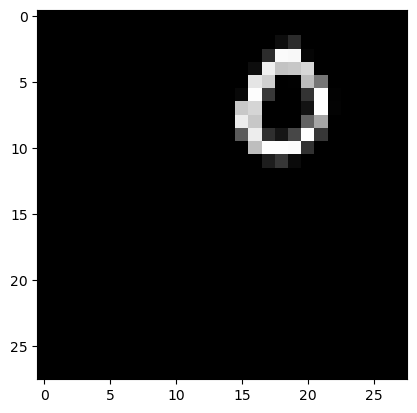

In [10]:
plt.imshow(a,cmap='gray')

In [5]:
## model, optimizer and loss function
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, out_channels=16, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(in_features=64*4*4, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        print(x.shape)
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x
model = Net()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)


max_epochs = 20
val_interval = 1
batch_size = 16

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
epoch_acc_values = list()
epoch_v_loss_values = list()
epoch_v_acc_values = list()

In [14]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.to('cuda')
    model.train()
    epoch_loss = 0
    num_correct = 0
    b = 0
    
    ### Training ###
    for b,(img,label) in enumerate(data_loader):

        # Forward and backward passes
        optimizer.zero_grad()
        img,label = img.to('cuda'),label.to('cuda')
        outputs = model(img)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, label)
        num_correct += (predictions.cpu() == label.cpu()).sum()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (b%1000 == 0):
            #print(f"Batch {b}")
            #print(f"train_loss: {loss.item():.4f}")

            epoch_loss /= b
            epoch_loss_values.append(epoch_loss)
            epoch_acc = num_correct/len(imagenet_data)
            epoch_acc_values.append(epoch_acc)
            #print(f"average loss: {epoch_loss:.4f}; accuracy: {epoch_acc:.4f}")

    ### Validation ###
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        v_num_correct = 0
        with torch.no_grad():
            for b,(img,label) in enumerate(data_loader_val):# create batch data
                img,label = img.to('cuda'),label.to('cuda')
                outputs = model(img)
                loss = loss_function(outputs, label)
                _, predictions = torch.max(outputs, 1)
                epoch_loss += loss.item()
                v_num_correct += (predictions.to('cpu') == label.to('cpu')).sum()

            epoch_loss /= b
            epoch_v_loss_values.append(epoch_loss)
            epoch_acc = v_num_correct/len(img)
            epoch_v_acc_values.append(epoch_acc)
            if epoch_acc > best_metric:
                best_metric = epoch_acc
                best_metric_epoch = epoch + 1
                model_dir = "./best_model_3A.pth"
                torch.save(model.state_dict(), model_dir)
                print("saved new best metric model")
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/20


KeyboardInterrupt: 

In [6]:
from medcam import medcam
import torch
import torch.nn as nn
model = Net()
torch.load('./best_model_3A.pth').keys()
model.load_state_dict(torch.load('./best_model_3A.pth'))

<All keys matched successfully>

In [7]:
from torch.nn import functional as F
model.to('cpu')

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)

In [8]:
for i,(img,label) in enumerate(data_loader_val):
    img,label = img.to('cpu'),label.to('cpu')
    break

In [9]:
rs = model(torch.tensor(img))
rs = torch.argmax(rs,dim=1)
rs

torch.Size([16, 64, 4, 4])


C:\Users\098986\AppData\Local\Temp\ipykernel_27424\3961741002.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rs = model(torch.tensor(img))


tensor([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
myCNN = medcam.inject(model, layer='conv1',backend='gcam',output_dir='./attention_map/',label=4,save_maps=True)

In [11]:
myCNN.get_layers

<bound method get_layers of Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)>

In [15]:
rs

tensor([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

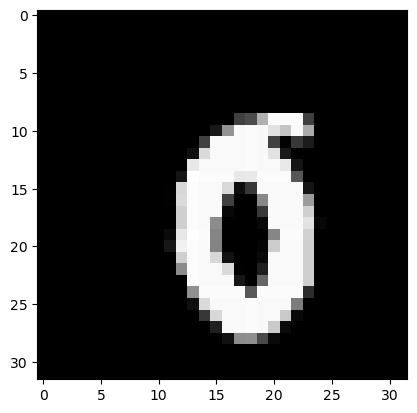

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import matplotlib.pyplot as plt
plt.imshow(img[5][0],cmap='gray')

In [19]:
myCNN.eval()
myCNN.to('cpu')
myCNN(torch.tensor(img))

C:\Users\098986\AppData\Local\Temp\ipykernel_27424\3153884726.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  myCNN(torch.tensor(img))


torch.Size([16, 64, 4, 4])
torch.Size([16, 64, 4, 4])


tensor([[  2.0875,  -2.8560,  -0.6132,  -8.2032,  -1.6201,  -0.2062,   0.6220,
          -6.6483,  -2.7233,  -6.6876],
        [  5.7009,  -9.9248,  -4.6675,  -9.2508,  -9.4032,  -4.8478,  -7.5242,
          -4.5756,  -3.6522,  -0.2494],
        [  5.5919,  -9.1296, -16.7202, -16.8775, -11.0151,  -1.9988,  -5.6650,
         -23.1453, -10.1388, -11.0231],
        [  5.5641, -10.4807,  -2.6004, -11.8362,  -7.0981,  -2.7122,  -2.3312,
          -8.4875,  -1.5871,  -5.6688],
        [  6.9100,  -5.5385,  -4.1385, -13.8473,  -6.3131,  -2.6756,  -2.7731,
          -8.8707,  -6.9274,  -9.6024],
        [  0.3633, -12.4584, -18.2754, -16.8350,  -9.9712,   3.5327,  -6.1111,
         -11.1442,  -0.0981,  -5.6559],
        [  8.6869,  -5.0519,  -9.4583, -16.8502,  -9.0068,  -8.1148,  -9.8008,
         -14.6985,  -9.8299,  -9.9242],
        [ 11.0021, -14.8687, -14.3701, -25.7312, -13.8497,  -7.9729,  -8.9653,
         -18.5419, -12.0895, -12.6590],
        [  2.9982,  -6.3592,  -1.3284,  -3.1732,

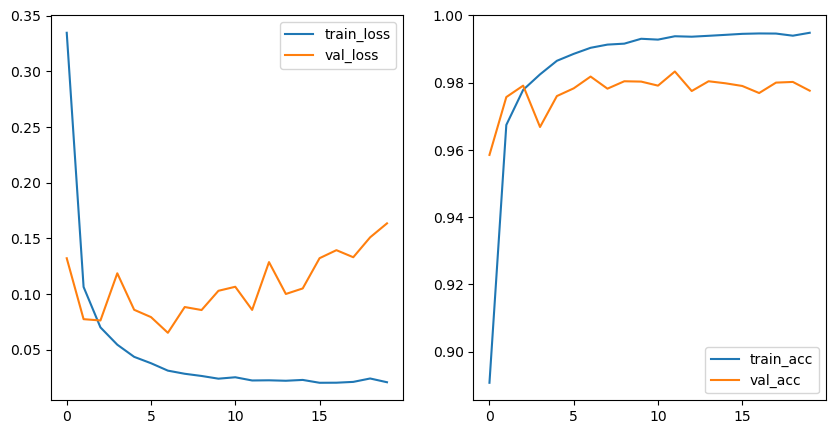

In [39]:
# draw loss and accuracy curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_values, label='train_loss')
plt.plot(epoch_v_loss_values, label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epoch_acc_values, label='train_acc')
plt.plot(epoch_v_acc_values_, label='val_acc')
#legend right left


#  
plt.legend(loc='lower right')
plt.show()

# Q14


In [147]:
#global pooling
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, out_channels=16, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))


        b,c,h,w = x.shape
        x = x.view(b,c,-1)
        #x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer
        #global pooling
        #x = torch.argmax(x,dim=2).float()
        x = torch.argmax(x,dim=2).float()
        x = self.fc(x)
        return x
model = Net()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)


max_epochs = 20
val_interval = 1
batch_size = 16

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
epoch_acc_values = list()
epoch_v_loss_values = list()
epoch_v_acc_values = list()

In [4]:
import os
from glob import glob
from PIL import Image
image_paths = glob('./mnist-varres/train/**/*.png')  # 或者任何其他图像格式

def get_list_of_data(dataloader):
    all_images = []
    all_labels = []
    for images, labels in dataloader:
        all_images.extend(images)
        all_labels.extend(labels)
    return all_images, all_labels

#a list will be used to group different image resolution

sizes = {(32,32):0,(48,48):1,(64,64):2}


all_images,all_labels = get_list_of_data(data_loader)
all_images_val,all_labels_val = get_list_of_data(data_loader_val)

        
all_images_group = [[] for size in range(len(sizes))]
all_labels_group = [[] for size in range(len(sizes))]

all_images_group_val = [[] for size in range(len(sizes))]
all_labels_group_val = [[] for size in range(len(sizes))]




#number of each size
for img,label in zip(all_images,all_labels):
    size = tuple(img[0,:,:].shape)
    index = sizes[size]
    all_images_group[index].append(img)
    all_labels_group[index].append(label)


for img,label in zip(all_images_val,all_labels_val):
    size = tuple(img[0,:,:].shape)
    index = sizes[size]
    all_images_group_val[index].append(img)
    all_labels_group_val[index].append(label)

In [7]:
#global mean pooling more depth more pars
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, out_channels=16, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64,397,(3,3),stride=1,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(in_features=397, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))


        b,c,h,w = x.shape
        x = x.view(b,c,-1)
        #x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer
        #global pooling
        #x = torch.argmax(x,dim=2).float()
        x = torch.mean(x,dim=2).float()
        x = self.fc(x)
        return x
model = Net()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)


max_epochs = 20
val_interval = 1
batch_size = 16

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
epoch_acc_values = list()
epoch_v_loss_values = list()
epoch_v_acc_values = list()

In [33]:
#global mean pooling larger kenerl size
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, out_channels=16, kernel_size=(5,5), stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, out_channels=32, kernel_size=(5,5), stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, out_channels=64, kernel_size=(5,5), stride=1, padding=2)
        self.conv4 = nn.Conv2d(64,128,(5,5),stride=1,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(in_features=128*2*2, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))


        b,c,h,w = x.shape
        #print(h,w,666)
        x = x.view(b,c,-1)
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer
        #global pooling
        #x = torch.argmax(x,dim=2).float()
        #x = torch.mean(x,dim=2).float()
        x = self.fc(x)
        return x
model = Net()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)


max_epochs = 20
val_interval = 1
batch_size = 16

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
epoch_acc_values = list()
epoch_v_loss_values = list()
epoch_v_acc_values = list()

In [16]:
len(all_images_group[1])

20080

In [25]:

batch_size = 16
num_correct = 0
epoch_loss = 0
epoch_tr_acc = []
epoch_val_acc = []
for epoch in range(max_epochs):
    model.to('cuda')
    num_correct = 0
    epoch_loss = 0
    model.train()
    for images_group,labels_group in zip(all_images_group,all_labels_group):
        #print(len(images_group))
        for i in range(0,len(images_group)//batch_size):
            model.train()
            optimizer.zero_grad()
            tr_imgs = torch.stack(images_group[i:i+batch_size])
            tr_labels = torch.stack(labels_group[i:i+batch_size])
            tr_imgs,tr_labels = tr_imgs.to('cuda'),tr_labels.to('cuda')
            #print(tr_imgs.shape)
            #print(tr_labels.shape)
            optimizer.zero_grad()
            outputs = model(tr_imgs)
            _, predictions = torch.max(outputs.cpu(), 1)
            loss = loss_function(outputs, tr_labels)
            num_correct += (predictions.cpu() == tr_labels.cpu()).sum()

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            #print('this is batch',i,'loss',loss.item())
            

    epoch_loss = epoch_loss/(len(all_images)//batch_size)
    epoch_loss_values.append(epoch_loss)
    epoch_acc = num_correct / len(all_images)
    epoch_acc_values.append(epoch_acc)
    print(f"average train loss: {epoch_loss:.4f}; accuracy: {epoch_acc:.4f}")
    

    ### Validation ###
    num_correct = 0
    epoch_loss = 0
    model.eval()

    
    for images_group,labels_group in zip(all_images_group_val,all_labels_group_val):
        #print(len(images_group))
        for i in range(0,len(images_group)//batch_size):
            val_imgs = torch.stack(images_group[i:i+batch_size])
            val_labels = torch.stack(labels_group[i:i+batch_size])
            val_imgs,val_labels = val_imgs.to('cuda'),val_labels.to('cuda')
            #print(tr_imgs.shape)
            #print(tr_labels.shape)

            with torch.no_grad():
                outputs = model(val_imgs)
                _, predictions = torch.max(outputs, 1)
                loss = loss_function(outputs, val_labels)
                num_correct += (predictions.cpu() == val_labels.cpu()).sum()
                epoch_loss += loss.item()
    epoch_loss  = epoch_loss/(len(all_images_val)//batch_size)
    epoch_v_loss_values.append(epoch_loss)
    epoch_acc = num_correct/len(all_images_val)
    epoch_v_acc_values.append(epoch_acc)
    print(f"average val loss: {epoch_loss:.4f}; accuracy: {epoch_acc:.4f}")

        


average train loss: 0.1850; accuracy: 0.9448
average val loss: 0.0711; accuracy: 0.9706
average train loss: 0.0307; accuracy: 0.9933
average val loss: 0.0994; accuracy: 0.9792
average train loss: 0.0127; accuracy: 0.9973
average val loss: 0.1528; accuracy: 0.9824
average train loss: 0.0123; accuracy: 0.9979
average val loss: 0.0527; accuracy: 0.9920
average train loss: 0.0086; accuracy: 0.9983
average val loss: 0.1559; accuracy: 0.9840
average train loss: 0.0077; accuracy: 0.9985
average val loss: 0.0726; accuracy: 0.9872
average train loss: 0.0102; accuracy: 0.9984
average val loss: 0.0389; accuracy: 0.9920
average train loss: 0.0054; accuracy: 0.9988
average val loss: 0.2581; accuracy: 0.9760
average train loss: 0.0082; accuracy: 0.9986
average val loss: 0.1336; accuracy: 0.9822
average train loss: 0.0059; accuracy: 0.9990
average val loss: 0.1188; accuracy: 0.9862
average train loss: 0.0016; accuracy: 0.9994
average val loss: 0.3812; accuracy: 0.9758
average train loss: 0.0074; accu

In [29]:
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 397, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=397, out_features=10, bias=True)
)

In [130]:
model(torch.randn(1,1,32,32))

TypeError: linear(): argument 'input' (position 1) must be Tensor, not module

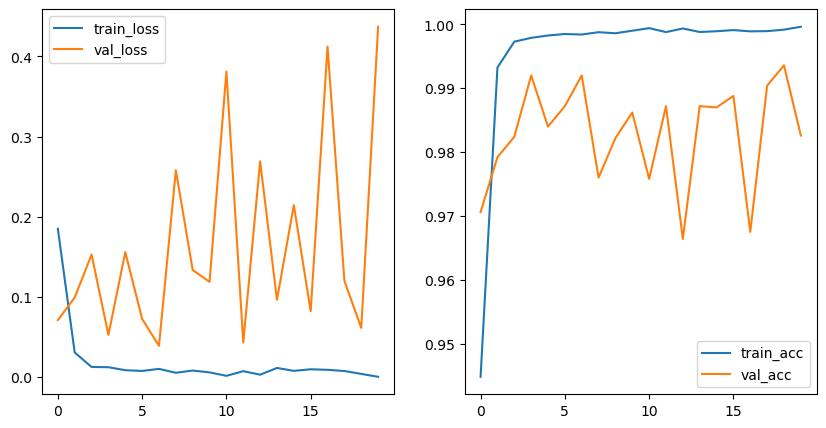

In [27]:
#global mean pooling with more pars
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_values, label='train_loss')
plt.plot(epoch_v_loss_values, label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epoch_acc_values, label='train_acc')
plt.plot(epoch_v_acc_values, label='val_acc')
#legend right left
plt.legend(loc='lower right')
plt.show()

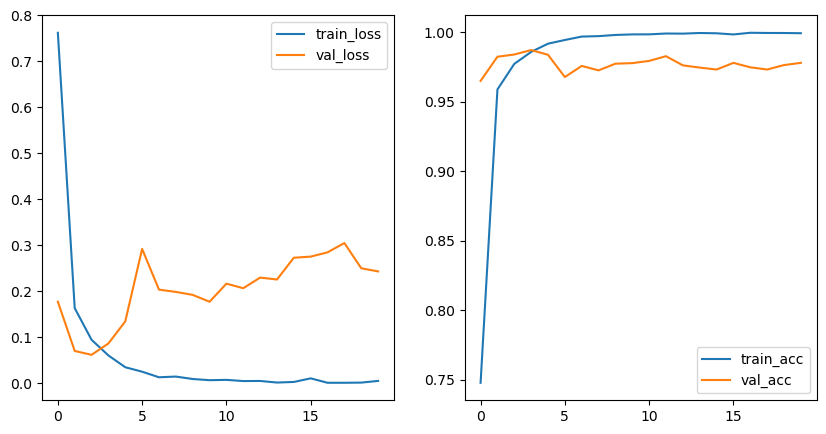

In [119]:
#global pooling mean

#plot loss and accuracy curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_values, label='train_loss')
plt.plot(epoch_v_loss_values, label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epoch_acc_values, label='train_acc')
plt.plot(epoch_v_acc_values, label='val_acc')
#legend right left
plt.legend(loc='lower right')
plt.show()


In [45]:
lin_1 = nn.Linear(in_features=64, out_features=10)
lin_1(torch.rand(16,64))

tensor([[ 5.6768e-01, -7.5309e-02,  5.0267e-01, -5.3996e-01,  6.1574e-01,
         -3.0186e-01, -9.8647e-02,  8.5058e-02, -2.4552e-01,  1.8871e-01],
        [ 3.3603e-01, -3.1246e-01,  4.8372e-01, -3.6972e-01,  4.0944e-01,
         -1.3681e-01,  1.7378e-01,  7.0685e-01, -1.0120e-01,  4.2083e-01],
        [ 5.7459e-01, -2.8741e-01,  4.4277e-01, -2.6385e-01,  6.2772e-01,
         -6.7750e-03, -3.1234e-01,  3.6205e-01, -3.4157e-01,  2.8970e-01],
        [ 2.4866e-01, -2.3192e-01,  2.1058e-01, -8.5826e-01,  6.7884e-01,
          9.0497e-02, -2.9417e-01,  5.5710e-01, -2.3115e-01,  3.5077e-02],
        [ 4.4243e-01, -1.6457e-01,  1.1024e-01, -3.9048e-01,  4.9641e-01,
          6.4267e-02, -3.0494e-02,  4.2664e-01, -2.4632e-01,  1.4963e-01],
        [ 4.3567e-01, -1.6720e-01, -7.4261e-03, -3.7798e-01,  2.6755e-01,
         -1.6826e-01,  1.8569e-01,  4.5939e-01, -1.0514e-01,  2.7465e-01],
        [ 4.7002e-01, -3.3919e-01,  1.8001e-01, -4.5552e-01,  7.2283e-01,
          2.8072e-01, -1.4014e-0

In [142]:
all_images

[[<PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=32x32>,
  <PIL.PngImagePlugin.Pn

In [141]:
torch.utils.data.TensorDataset(all_images[0],all_labels[0])

NameError: name 'all_labels' is not defined

In [140]:
#for each size creat a dataloader
dataloaders = []
for images in all_images:
    dataset = torch.utils.data.TensorDataset(images)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
    dataloaders.append(dataloader)

AttributeError: 'list' object has no attribute 'size'

In [ ]:

# 输出每个尺寸及其对应的图像路径
for size, paths in size_to_images.items():
    print(f"Size: {size}")
    for path in paths:
        print(f" - {path}")